### Implementation of Mistic 
to our binary description of patient data

In [1]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

/blue/ferrallm/mcremer/cardiac-amyloidosis


### libraries and dirrectories

In [2]:
#set dirrectory
import os
starting_directory = os.getcwd()

#helps when fetching the functions and classes from mistic  
# new_dirrectory = 'C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Shared-From-DrK/mistic_breast_cancer_example/mistic_breast_cancer_example'
new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)



In [3]:
# Import packages/modules
import matplotlib.pyplot as plt   
plt.rcParams.update({'font.size': 8})

import numpy as np
import pandas as pd

from statistics import mean 
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from seaborn import clustermap, heatmap

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel

# Import functions
from mistic_v1 import greedy_backward_selection, tuneSVM, compute_SV_feature_importance, compute_counterfactuals #, compute_SV_feature_contribution
from mistic_v1 import compute_SV_gradient_rank2, compute_SV_importance_rank, compute_SV_contribution_rank, compute_SV_decision_perturbation

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from scipy.stats import pearsonr
from mistic_v1 import rank_items

class SV_combined_rank():

    def __init__(self,weight=0.5):
        self.weight = weight

    def compute(self,svc,X,y):
        contribution_rank = compute_SV_contribution_rank(svc,X,y)
        importance_rank = compute_SV_importance_rank(svc,X,y)

        consensus_rank = self.weight*contribution_rank + (1-self.weight)*importance_rank
        rank = rank_items(consensus_rank)
        
        return rank

class svc_score():

    def __init__(self, weight=0.5):
        self.weight = weight

    def score(self,svc,X,y):
        y_pred = svc.predict(X)
        
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        if (tp+fp) > 0:
            precision = tp/(tp+fp)
        else:
            precision = 0
            
        if (tp+fn) > 0:
            recall = tp/(tp+fn)
        else:
            recall = 0
        
        if (precision+recall) > 0:
            f1 = 2*precision*recall/(precision+recall)
        else:
            f1 = 0
            
        auc = roc_auc_score(y, svc.decision_function(X))
        score = self.weight*auc + (1-self.weight)*f1
            
        return pd.DataFrame(data={'f1': f1, 'auc': auc, 'score': score},index=[0])


In [5]:
import shap
from mistic_v1 import compute_SV_integrated_gradient

In [6]:
import plotly.express as px
from seaborn import pairplot, load_dataset

In [7]:
import numpy as np
import pickle

In [8]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

### importing our data

In [9]:
#consider changing dirrectory back to a space to save your data that isn't the mistic folder

# new_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/SVM_Mistic_Output_2024-07-12_v2"
# os.chdir(new_dirrectory)

#for file outputs
fileName_header = "AllLabs_240716_fitRed05" #what data did you put in
fileName_common = "_MisticOutput_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_2024-07-23_v1" #date and versioning

# saving_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
saving_dirrectory = "012 Processed Data"
makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "SVM_Mistic_Output_AllLabs_05FitRed", folderName_common= "2024-07-23_", 
                                     folderName_suffix= "v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder #"SVM_Mistic_Output_2024-07-19_v2"



In [10]:
#file name for inputs
#file full with directory
# fileInput_directory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/DFsForSVM_2024-07-12_v1/AL-KnownPts-top38labs-wFill-tx-Summary-One_2024-07-12_v1.xlsx"
fileInput_directory = 'AL-KnownPts-labsAll-wFill-tx-Summary-One_2024-07-16_v1.xlsx'

In [11]:
# # Import dataset

dataTable = pd.read_excel(fileInput_directory, header = 0)
dataTable

DeID  Amyloid Status  Dx  Sex  Age  Survival (in months)  \
0   B-02               2   1    0   48              9.466667   
1   C-03               2   2    1   59             17.000000   
2   E-01               2   1    0   50             71.300000   
3   E-02               2   1    0   64             20.466667   
4   F-03               2   2    0   61             52.000000   
5   G-01               2   2    0   70            104.000000   
6   G-02               2   2    1   36             30.000000   
7   I-01               2   2    1   55             33.000000   
8   I-03               2   1    0   67             10.033333   
9   J-02               2   2    1   68             26.000000   
10  K-01               2   1    1   70             93.900000   
11  K-02               2   2    1   68             27.000000   
12  L-02               2   2    0   56              6.000000   
13  M-02               2   1    0   70             24.800000   
14  N-03               2   2    0   69              8.000000   
15  O-03               2   2    1   71              4.233333   
16  Q-02               2   1    0   69             41.100000   
17  Q-03               2   2    1   41              3.466667   
18  T-01               2   0    0   71             14.433333   
19  V-02               2   2    0   79             50.000000   
20  W-01               2   2    0   57             42.000000   
21  X-01               2   1    0   80              5.300000   
22  X-02               2   1    0   63             38.233333   
23  Y-02               2   1    1   57             12.766667   
24  A-02               1   1    1   74              7.266667   
25  B-03               1   2    0   43             18.000000   
26  C-01               1   0    1   56             27.000000   
27  C-02               1   2    0   59             33.000000   
28  E-03               1   1    0   62             13.866667   
29  F-01               1   2    0   55            147.000000   
30  G-03               1   1    1   69             11.533333   
31  H-01               1   1    0   56             47.066667   
32  H-02               1   2    0   65             26.000000   
33  J-01               1   2    0   60             94.000000   
34  M-01               1   2    0   47             83.000000   
35  N-01               1   0    0   79             15.000000   
36  N-02               1   2    0   76             10.000000   
37  P-01               1   2    0   77             53.000000   
38  P-02               1   2    1   64             26.000000   
39  Q-01               1   1    1   57             48.800000   
40  R-01               1   2    0   68             21.000000   
41  R-03               1   1    1   62             12.966667   
42  S-02               1   2    1   69             20.000000   
43  T-02               1   2    0   60             19.000000   
44  V-01               1   2    1   66             43.000000   
45  W-02               1   1    0   72             13.500000   
46  Y-01               1   2    0   59             40.000000   
47  Z-01               1   0    1   72              2.000000   

    time from diagnosis to first echo (months)  1st_EF(avg%)  \
0                                     4.433333          67.5   
1                                    -0.033333          62.5   
2                                    21.666667          62.0   
3                                     2.100000          60.0   
4                                    -1.000000          -1.0   
5                                   102.166667          55.0   
6                                     4.400000          50.0   
7                                     1.133333          62.5   
8                                     1.633333          57.5   
9                                     0.900000          47.5   
10                                   86.000000          42.0   
11                                    0.566667          62.5   
12                                 

In [12]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status']


#columns to use for the y data 
y_column_Classification = 'Amyloid Status'

### scale data

In [13]:
# Scale input X
X = dataTable.copy()
X.drop(columns= x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X) #computes the mean and STD along the features axis

X_train_all = scaler.transform(X) #standardization by centering and scaling
y_train_all = dataTable[y_column_Classification]
X_train_all

array([[-0.74270874, -0.77459667, -1.52139307, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [ 0.8072921 ,  1.29099445, -0.40879537, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [-0.74270874, -0.77459667, -1.31910258, ..., -0.14586499,
        -0.20851441, -0.20851441],
       ...,
       [-0.74270874, -0.77459667,  0.90609283, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [ 0.8072921 , -0.77459667, -0.40879537, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [-2.29270958,  1.29099445,  0.90609283, ..., -0.14586499,
        -0.20851441, -0.20851441]])

In [14]:
#pickling the test and train sets 
pickle_file_name = 'X_train_all_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(X_train_all, pickle_file)

pickle_file_name = 'y_train_all_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(y_train_all, pickle_file)

In [15]:
#pickling the scalar so that new data can be applied and mapped to use this classifier
pickle_file_name = 'scaler_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(scaler, pickle_file)

In [16]:
# # loading from pickled objects
# #to upload a pickled set use this block
# pickle_file_name = 'X_train_all_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# X_train_all = pickle.load(pickle_file)

# #uploading the y train object
# pickle_file_name = 'y_train_all_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# y_train_all = pickle.load(pickle_file)

### creating the classifier

In [17]:
# Number of training sets
NT = 5 

# Data split ratio
val_size = 1/NT

#Feature selection reduction factor
red_factor = 0.5

In [18]:
# split train set into train and test(val) data / repeat NT times and |get NT number of datsets
CV_sets = []
for i in range(NT):
    X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, 
                                                        stratify = y_train_all, 
                                                        random_state= i, 
                                                        test_size= val_size)
    
    CV_set = {"train": {"X": X_train,"y": y_train}, "test":  {"X": X_test, "y": y_test}} 
    CV_sets.append(CV_set)

In [ ]:
#pickling the CV sets object
pickle_file_name = 'CV_sets_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(CV_sets, pickle_file)

In [ ]:
# #to upload a pickled set use this block
# pickle_file_name = 'CV_sets_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# CV_sets = pickle.load(pickle_file)

In [19]:
C_range = [2**x for x in range(-2,5)] # trade-off between margin and misclassifications.  smaller c, wider margins
gamma_range = [2**x for x in range(-9,1)]

svc = SVC(kernel = 'rbf', class_weight="balanced", probability=False)

In [20]:
#create tesTune, the first classifier using all the features

In [21]:
tesTune = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range)
tesTune["best_params"]

c  g        f1  auc     score
0  0.25  1  0.666667  0.5  0.583333

In [22]:
#saving the first test tune set
perf = tesTune["performance"]
tesTune_best_params = tesTune["best_params"]

outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "tesTune perf")
outputToExcel(df_data=tesTune_best_params, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "tesTune best params")

In [23]:
#pickling the tesTune object
pickle_file_name = 'tesTune_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(tesTune, pickle_file)

In [24]:
# #to upload a pickled set use this block
# pickle_file_name = 'tesTune_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# tesTune = pickle.load(pickle_file)

In [25]:
tesTune["best_models"][0].classes_

array([1, 2])

## greedy_backward_selection

featRank_A fresh compile

In [26]:
featRank_A = greedy_backward_selection(svc, X_train_all, CV_sets, compute_SV_importance_rank, svc_score().score, C_range, gamma_range, redF = red_factor)

      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.666667  0.5  0.583333    7833      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3916      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.497363  0.576  0.536681    1957      19.0
      c       g       f1    auc     score  nFeats  mean_nSV
0  0.25  0.0625  0.81101  0.816  0.813505     978      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.003906  0.533333  0.624  0.578667     488      19.0
      c         g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.007812  0.685714  0.58  0.632857     243      19.0
      c         g       f1   auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.67619  0.52  0.598095     121      19.0
      c         g        f1  auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.666667  0.5  0.583333      60      19.0
      c         g        f1  auc     score  nFea

In [27]:
#if not already pickled use this block
pickle_file_name = 'featRankA_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_A, pickle_file)



In [28]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_A["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_A["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_A["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A best features")

df_bestModels= pd.DataFrame(featRank_A["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_A["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_A feature rank")

featRank_A upload from pickle

In [29]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankA_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_A = pickle.load(pickle_file)

compile featRank_B 

In [30]:
featRank_B = greedy_backward_selection(svc, X_train_all, CV_sets, compute_SV_contribution_rank, svc_score().score, C_range, gamma_range, redF = red_factor)

      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.666667  0.5  0.583333    7833      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3916      19.0
      c         g        f1    auc    score  nFeats  mean_nSV
0  0.25  0.001953  0.530519  0.608  0.56926    1957      19.0
      c         g       f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.64641  0.624  0.635205     978      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.842735  0.912  0.877368     488      19.0
    c         g        f1    auc     score  nFeats  mean_nSV
0  16  0.001953  0.834343  0.912  0.873172     243      15.4
   c         g        f1    auc     score  nFeats  mean_nSV
0  8  0.001953  0.887778  0.968  0.927889     121      12.8
   c         g        f1  auc     score  nFeats  mean_nSV
0  8  0.015625  0.959596  1.0  0.979798      60      16.0
    c         g   f1  auc  score  nFeats  mean_nSV

In [31]:
pickle_file_name = 'featRankB_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_B, pickle_file)

In [32]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_B["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_B["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_B["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B best features")

df_bestModels= pd.DataFrame(featRank_B["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_B["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_B feature rank")

load featRank_B from pickle

In [33]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankB_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_B = pickle.load(pickle_file)

compile featRank_C

In [34]:
featRank_C = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.25).compute, svc_score().score, C_range, gamma_range, redF = red_factor)

      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.666667  0.5  0.583333    7833      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3916      19.0
      c         g       f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.53619  0.536  0.536095    1957      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  1  0.015625  0.815455  0.832  0.823727     978      19.0
    c      g        f1  auc     score  nFeats  mean_nSV
0  16  0.125  0.711389  0.8  0.755694     488      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.003906  0.685714  0.596  0.640857     243      19.0
      c     g        f1   auc    score  nFeats  mean_nSV
0  0.25  0.25  0.687179  0.56  0.62359     121      19.0
      c         g        f1  auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.666667  0.5  0.583333      60      19.0
      c         g        f1  auc     score  nFeats  mean_nSV
0  0.25  

In [35]:
pickle_file_name = 'featRankC_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_C, pickle_file)

In [36]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_C["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_C["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_C["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C best features")

df_bestModels= pd.DataFrame(featRank_C["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_C["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_C feature rank")

upload featRank_C from pickle

In [37]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankC_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_C = pickle.load(pickle_file)

compile featRank_D

In [38]:
featRank_D = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.5).compute, svc_score().score, C_range, gamma_range, redF = red_factor)

      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.666667  0.5  0.583333    7833      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3916      19.0
      c         g       f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.45873  0.472  0.465365    1957      19.0
      c         g        f1   auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.709267  0.84  0.774634     978      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.784491  0.864  0.824246     488      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.850938  0.888  0.869469     243      19.0
   c         g        f1   auc     score  nFeats  mean_nSV
0  1  0.001953  0.851342  0.88  0.865671     121      18.4
   c        g        f1    auc     score  nFeats  mean_nSV
0  2  0.03125  0.855051  0.904  0.879525      60      15.4
    c         g        f1    auc     score  nF

In [39]:
pickle_file_name = 'featRankD_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_D, pickle_file)

In [40]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_D["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_D["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_D["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D best features")

df_bestModels= pd.DataFrame(featRank_D["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_D["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_D feature rank")

In [41]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankD_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_D = pickle.load(pickle_file)

comple featRank_E

In [42]:
featRank_E = greedy_backward_selection(svc, X_train_all, CV_sets, SV_combined_rank(weight=0.75).compute, svc_score().score, C_range, gamma_range, redF = red_factor)

      c  g        f1  auc     score  nFeats  mean_nSV
0  0.25  1  0.666667  0.5  0.583333    7833      19.0
      c  g        f1   auc     score  nFeats  mean_nSV
0  0.25  1  0.628571  0.46  0.544286    3916      19.0
      c         g        f1    auc     score  nFeats  mean_nSV
0  0.25  0.001953  0.517882  0.568  0.542941    1957      19.0
   c         g       f1   auc    score  nFeats  mean_nSV
0  1  0.001953  0.52022  0.56  0.54011     978      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  1  0.001953  0.812121  0.912  0.862061     488      19.0
   c         g        f1    auc     score  nFeats  mean_nSV
0  2  0.001953  0.875556  0.944  0.909778     243      16.8
   c         g       f1   auc     score  nFeats  mean_nSV
0  4  0.001953  0.90101  0.96  0.930505     121      13.4
   c         g        f1    auc     score  nFeats  mean_nSV
0  1  0.001953  0.883333  0.944  0.913667      60      19.0
    c         g        f1    auc     score  nFeats  mean_nSV
0  16

In [43]:
pickle_file_name = 'featRankE_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(featRank_E, pickle_file)

In [44]:
#saving the feature ranking, performance, and model evaluations to spreadsheets
perf = featRank_E["performance"]
# perf
outputToExcel(df_data=perf, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E performance")

df_columnNames_ranked = pd.DataFrame(list(X.columns[featRank_E["sorted"].astype(int)]))
#saving the column ranking
outputToExcel(df_data=df_columnNames_ranked, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E col ranked")

df_bestFeatures= pd.DataFrame(list(X.columns[featRank_E["best_features"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E best features")

df_bestModels= pd.DataFrame(featRank_E["best_models"])
#saving the best features
outputToExcel(df_data=df_bestModels, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E best models")

df_Rank= pd.DataFrame(list(X.columns[featRank_E["rank"].astype(int)]))
#saving the best features
outputToExcel(df_data=df_Rank, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
              folderName= dataFrameFolderOut, sheetName= "featRank_E feature rank")

In [45]:
# #to upload a pickled set use this block
# pickle_file_name = 'featRankE_object_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# featRank_E = pickle.load(pickle_file)

### Performance Plots

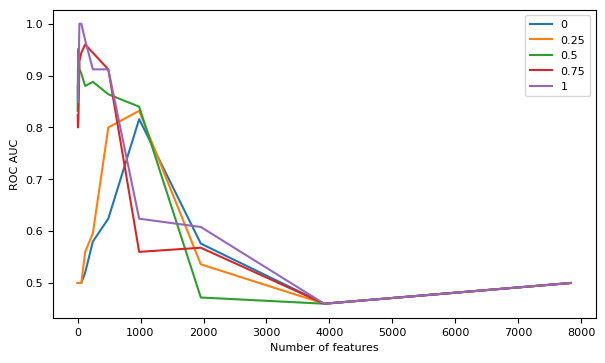

In [46]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].auc) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].auc) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].auc) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].auc)
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].auc) 

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()

In [47]:
#saving figure
# figDirectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
# figFolder = "SVM_Mistic_Draft_Output_2024-07-11_v1"
figCommon = fileName_common + "fig1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

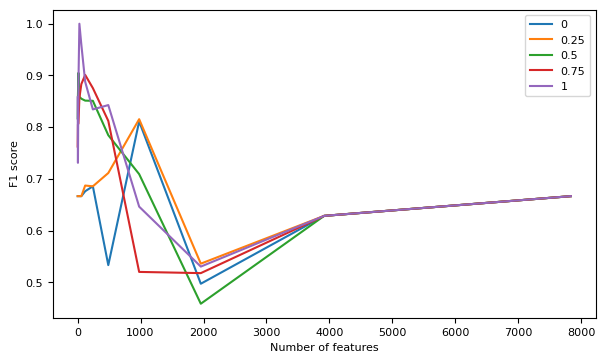

In [48]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].f1) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].f1) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].f1) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].f1) 
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].f1) 


plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.show()


In [49]:
figCommon = fileName_common + "fig2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

### Input the top 3 features from your data set into the following plot for a 3D visualization

In [50]:
X.columns[featRank_D["sorted"].astype(int)]

Index(['Kappa Free Light Chains Result (mg/L) Linear Forced R2',
       'Pct. Metamyelocyte Result Desc 50%', 'Testosterone Result Desc 50%',
       'Creatinine Result(mg/dL) Desc 25%',
       'Calcium Cation Electrolytes Value Result Desc 25%',
       'Albumin Electrophoresis Result Desc 75%',
       'Lambda Free Light Chains Result (mg/L) Linear Forced R2',
       'Testosterone Result Desc mean', 'Pct. Plasmacyte Result Desc 25%',
       'Pct. Metamyelocyte Result Desc 25%',
       ...
       'Urinalysis M Spike Result Linear NotForced RegresDesc mean',
       'Urinalysis M Spike Result Linear NotForced RegresDesc count',
       'Urinalysis M Spike Percent Result Linear NotForced RegresDesc max',
       'Urinalysis M Spike Percent Result Linear NotForced RegresDesc 75%',
       'Urinalysis M Spike Percent Result Linear NotForced RegresDesc 50%',
       'Urinalysis M Spike Percent Result Linear NotForced RegresDesc 25%',
       'Urinalysis M Spike Percent Result Linear NotForced Regre

In [51]:
listX = list(X.columns[featRank_D["sorted"].astype(int)])

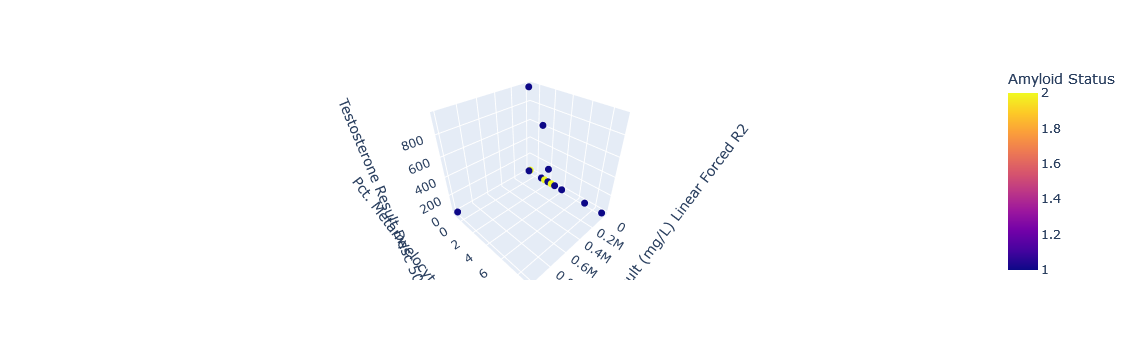

In [52]:
fig = px.scatter_3d(dataTable, x=listX[0], y=listX[1], z=listX[2],
              color= y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

### performance outputs
set the number of features you want to check the performance with

In [53]:
#setting number of features for performance test
fold = 0
number_feat_perf_test = 25 #describes for testing performance 
numb_features_figures = 5 #number of features to use in plots

In [54]:
# queryText = "nFeats == " + str(number_feat_perf_test)
# featRank_B["performance"].query(queryText)

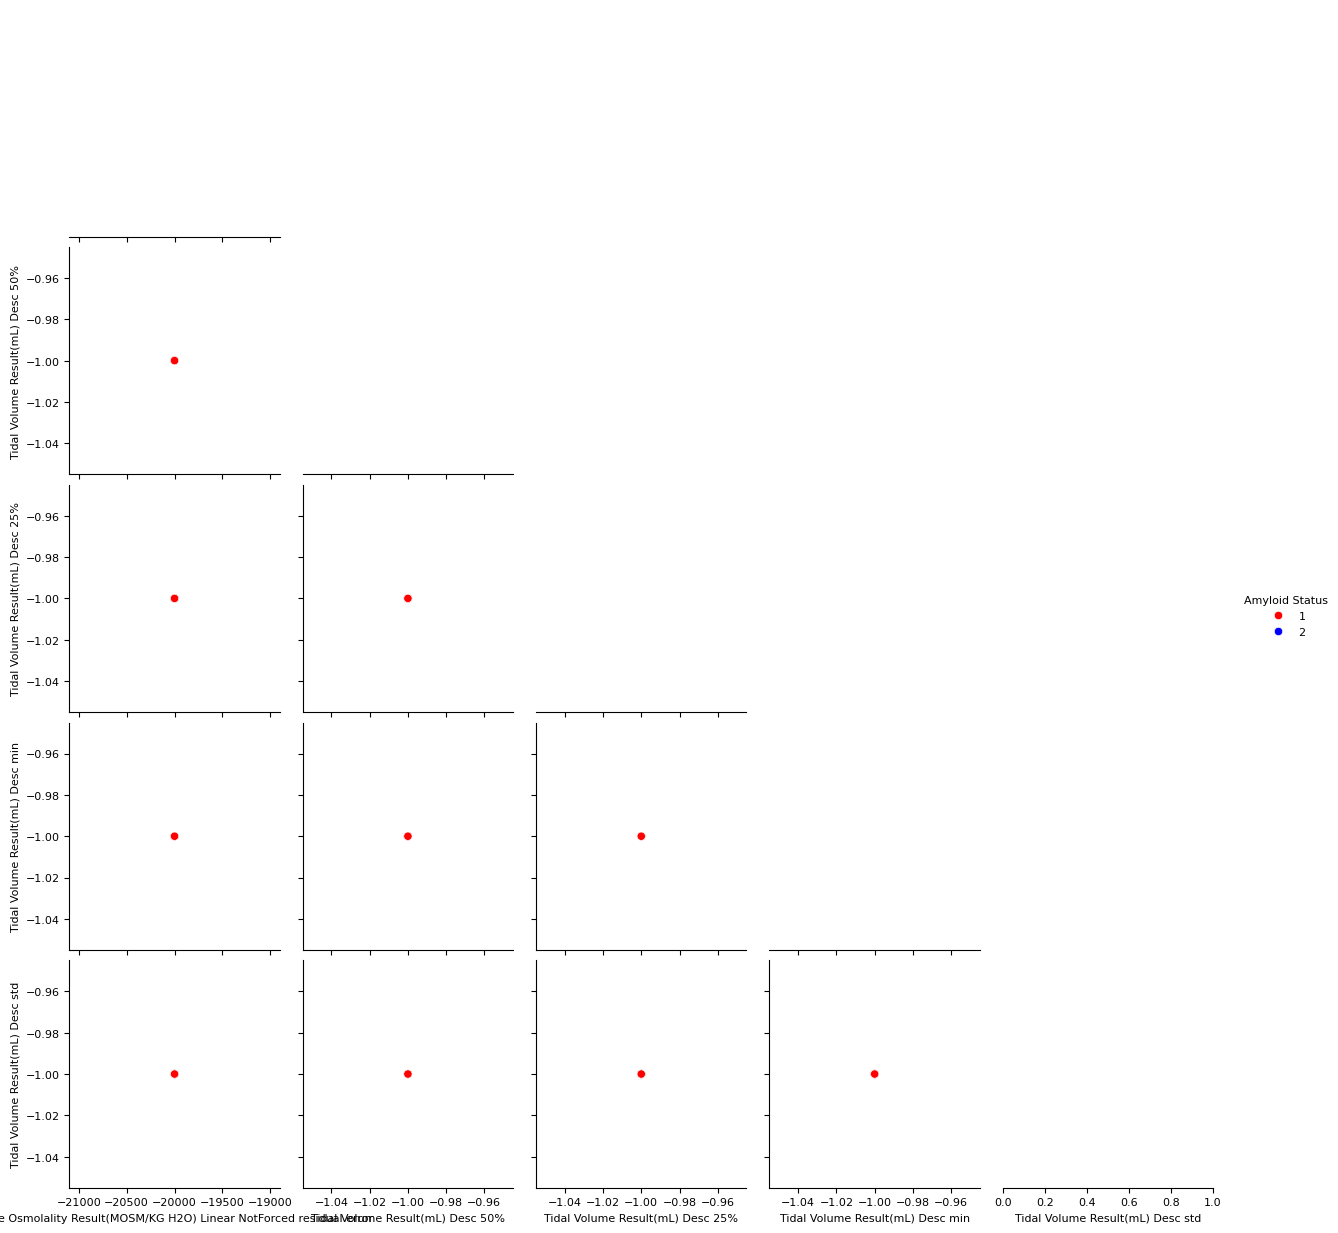

In [55]:
palette = {np.int64(1) :'red', np.int64(2): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_A["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A compare features")

figCommon = fileName_common + "featRankA"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

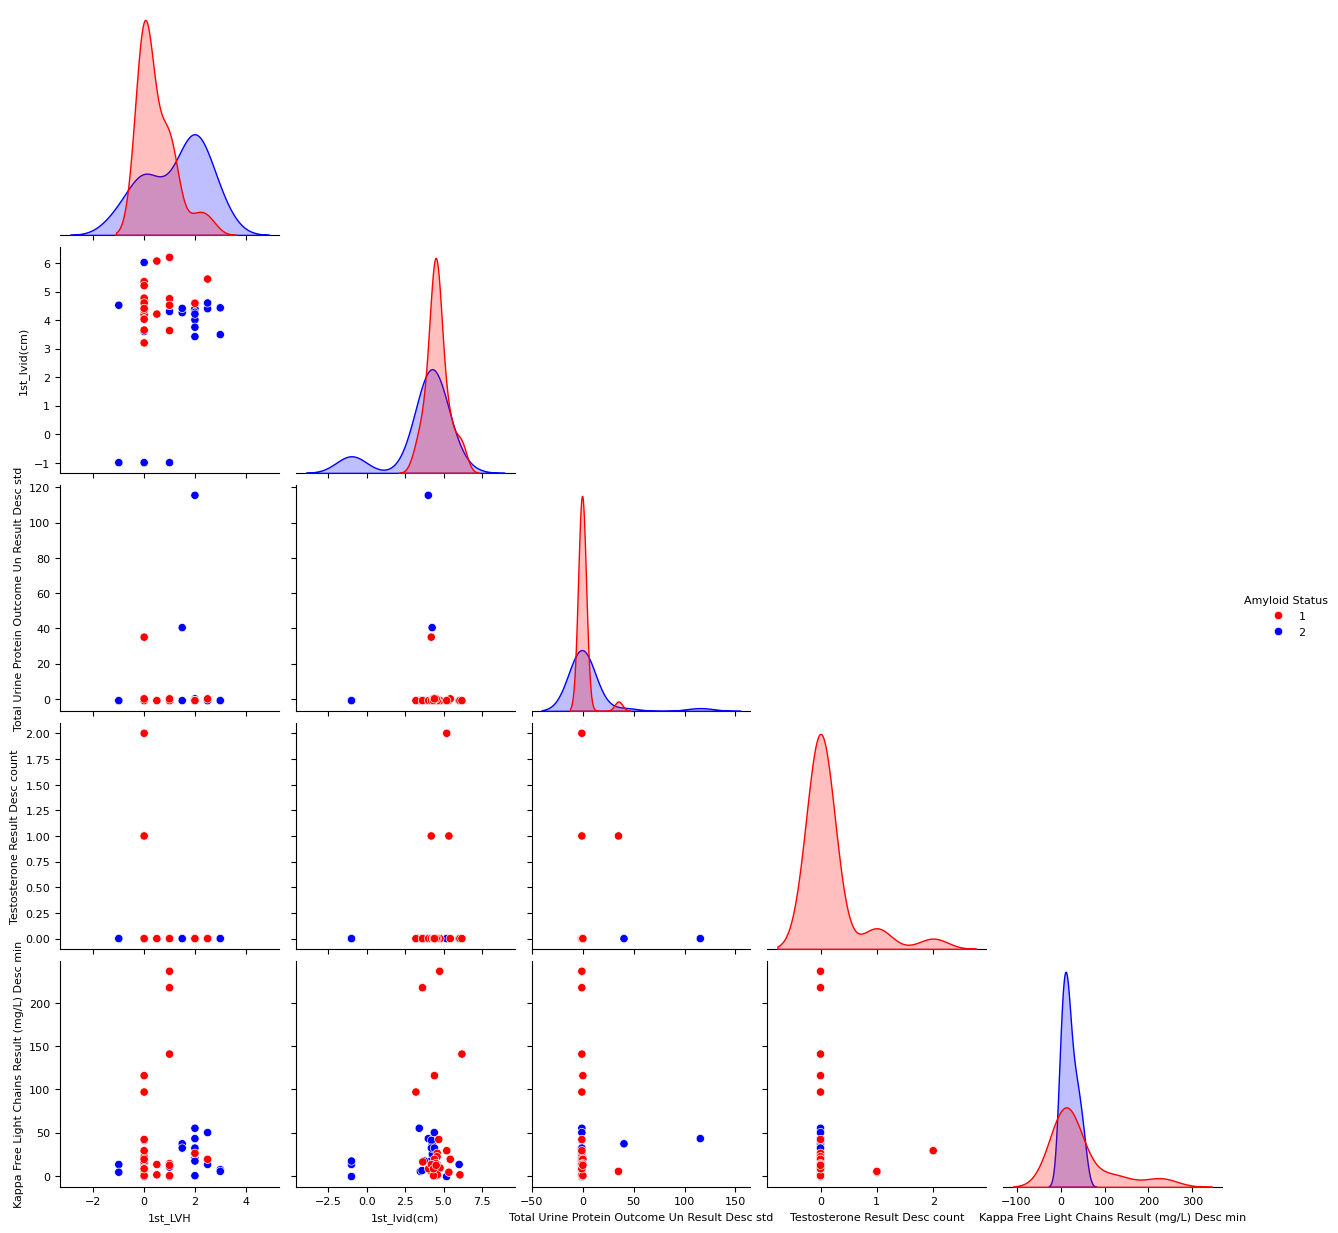

In [56]:
palette = {np.int64(1) :'red', np.int64(2): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_B["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A 5 features", loc = 'center')

figCommon = fileName_common + "featRankB_5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [57]:
# queryText = "nFeats == " + str(number_feat_perf_test)
# featRank_E["performance"].query(queryText)

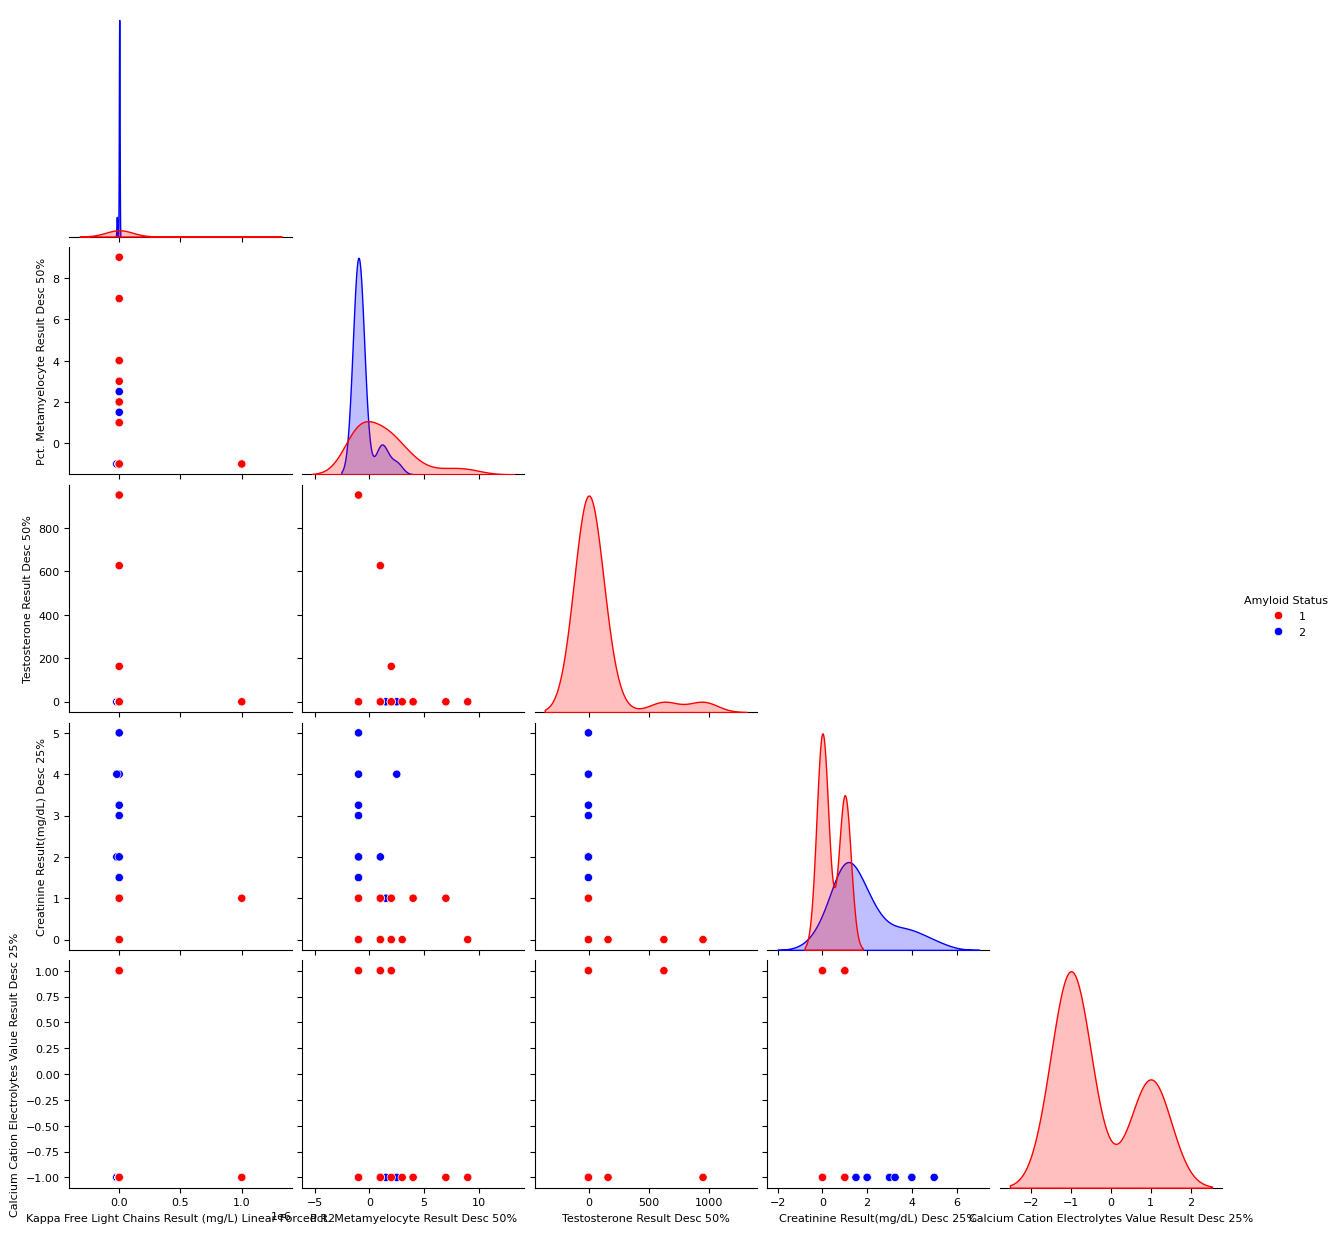

In [58]:
palette = {np.int64(1) :'red', np.int64(2): 'blue'} #our data is of int64
featuresToPlot = list(X.columns[featRank_D["sorted"].astype(int)][0:numb_features_figures])
featuresToPlot.extend([y_column_Classification]) #must include the final classification column 

fig = pairplot(dataTable[featuresToPlot],hue= y_column_Classification, corner=True, palette=palette)
# fig.title("featRank_A 5 features", loc = 'center')

figCommon = fileName_common + "featRankD_5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [59]:
# pairplot(dataTable[['Area worst', 'Concave Points worst', 'Texture worst','Diagnosis']],hue="Diagnosis", corner=True, palette={"M":"red","B":"blue"})

In [60]:
# tesTune2 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featRank_D["sorted"][0:10].astype(int))
# tesTune2["best_params"]

### hyper parameter tuning using the specified feature ranking and number of features

In [61]:
#find the best model and number of features... use that model 

#filtering by max score
maxscore = max(featRank_D["performance"]["score"])
queryText = "score == " + str(maxscore)
# print("max score: " , maxscore)
# print(featRank_D["performance"].query(queryText))

# #filtering by max f1
# maxF1 = max(featRank_D["performance"]["f1"])
# queryText = "f1 == " + str(maxF1) 
# print("max f1: ", maxF1) 
# print(featRank_D["performance"].query(queryText))

# #filtering by max auc
# maxF1 = max(featRank_D["performance"]["auc"])
# queryText = "auc == " + str(maxF1) 
# print("max auc: ", maxF1) 
# print(featRank_D["performance"].query(queryText))

modelSelected = featRank_D["performance"].query(queryText)
numbfeatures = int(modelSelected["nFeats"].iloc[0])
# print("number of features: ", numbfeatures)
# type(numbfeatures)

number_feat_perf_test = numbfeatures
numb_features_figures = numbfeatures

In [62]:
#pickling the number of features and the best model
pickle_file_name = 'modelSelected_performance_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(modelSelected, pickle_file)

pickle_file_name = 'numbfeatures_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(numbfeatures, pickle_file)

In [63]:
# #to upload a pickled set use this block
# pickle_file_name = 'modelSelected_performance_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# modelSelected = pickle.load(pickle_file)

# pickle_file_name = 'numbfeatures_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# numbfeatures = pickle.load(pickle_file)

## to use best features from a feature selection process

In [ ]:
modelD_Features = featRank_D["best_features"] #to get the best features which take highest score and highest C
modelD_FeaturesInt = featRank_D["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelD_numbFeatures = len(modelD_FeaturesInt) #number of features

#alternate way to find the column list for plots below 
modelD_FeaturesIntList = X.columns[featRank_D["best_features"][0:modelD_numbFeatures].astype(int)] #may not run

In [ ]:
modelE_Features = featRank_E["best_features"] #to get the best features which take highest score and highest C
modelE_FeaturesInt = featRank_E["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelE_numbFeatures = len(modelE_FeaturesInt) #number of features

#alternate way to find the column list for plots below 
modelE_FeaturesIntList = X.columns[featRank_E["best_features"][0:modelD_numbFeatures].astype(int)] #may not run

In [ ]:
modelB_Features = featRank_B["best_features"] #to get the best features which take highest score and highest C
modelB_FeaturesInt = featRank_B["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelB_numbFeatures = len(modelB_FeaturesInt) #number of features

#alternate way to find the column list for plots below 
modelB_FeaturesIntList = X.columns[featRank_B["best_features"][0:modelD_numbFeatures].astype(int)] #may not run

### next: 
replace the code below to get the columns you need.

## Figures for weighting 0.5

   c        g        f1    auc     score
0  2  0.03125  0.905051  0.952  0.928525


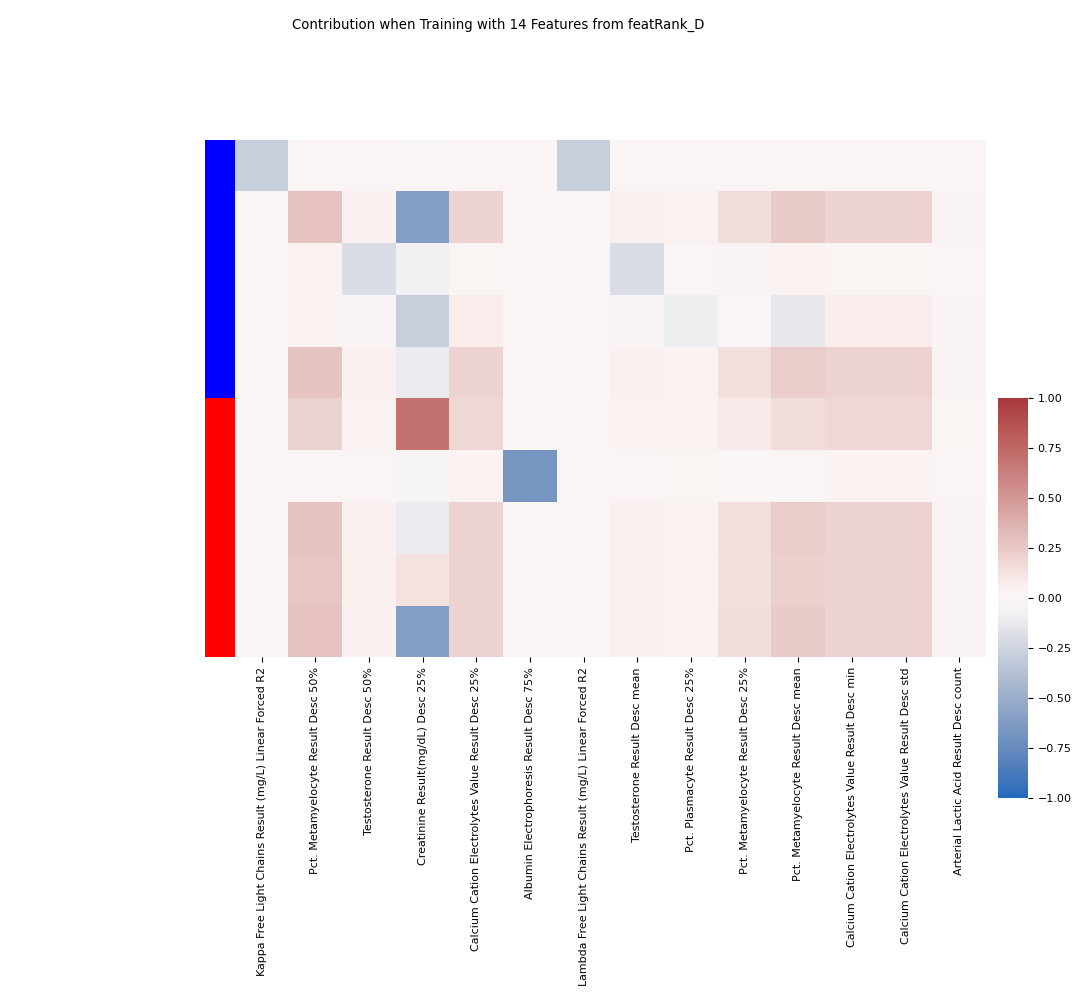

In [77]:
# import shap
# from mistic_v1 import compute_SV_integrated_gradient

# fold = 0
# number_feat_perf_test = 25
tesTune2 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featRank_D["sorted"][0:number_feat_perf_test].astype(int))
print(tesTune2["best_params"])

feat_contribution = compute_SV_decision_perturbation(tesTune2["best_models"][fold],CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:number_feat_perf_test].astype(int)])
FItable = pd.DataFrame(feat_contribution, index=CV_sets[fold]["test"]["y"],columns=X.columns[featRank_D["sorted"][0:number_feat_perf_test].astype(int)])

FItable.reset_index(drop=True, inplace=True)
fig = clustermap(FItable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
           yticklabels=False,
           cmap="vlag", vmin=-1, vmax=1,
           #row_linkage=hcRow, col_linkage=hcCol, 
           row_cluster=False,col_cluster=False,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
plt.suptitle("Contribution when Training with "+  str(number_feat_perf_test)+ " Features from featRank_D")

figCommon = fileName_common + "fig3"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/seaborn/matrix.py:615: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.

/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



RecursionError: maximum recursion depth exceeded

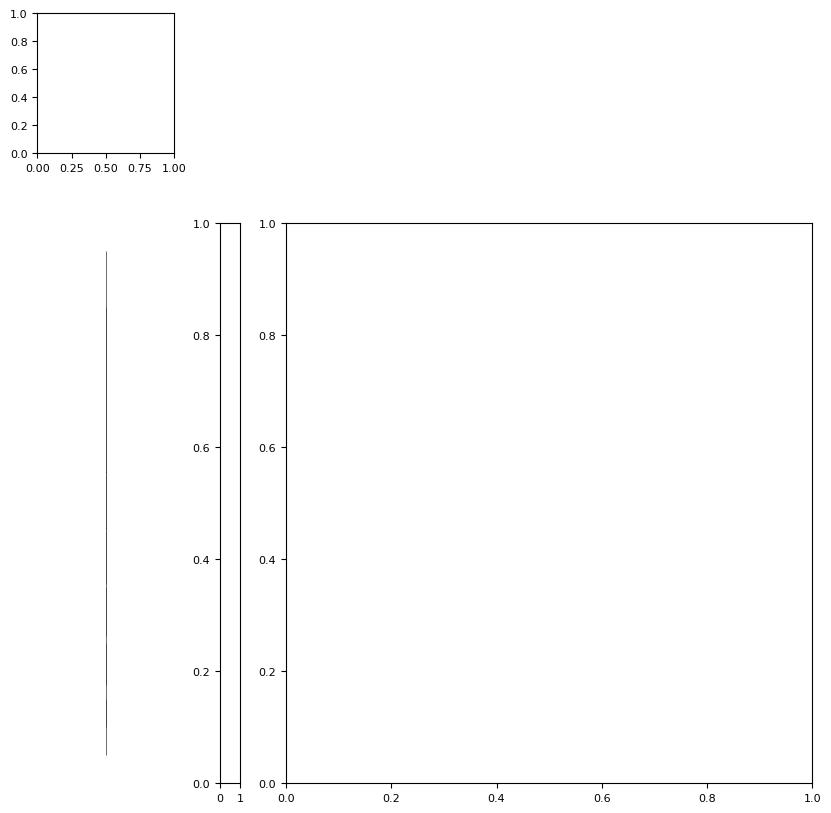

In [65]:
IG = compute_SV_integrated_gradient(tesTune["best_models"][0], CV_sets[0]["test"]["X"])

IGtable = pd.DataFrame(IG,columns=X.columns)

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-0.2, vmax=0.2,
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[0]["test"]["y"].values])
plt.suptitle("Integrated Gradient Parameters on Test Data")
plt.show()

figCommon = fileName_common + "fig4"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

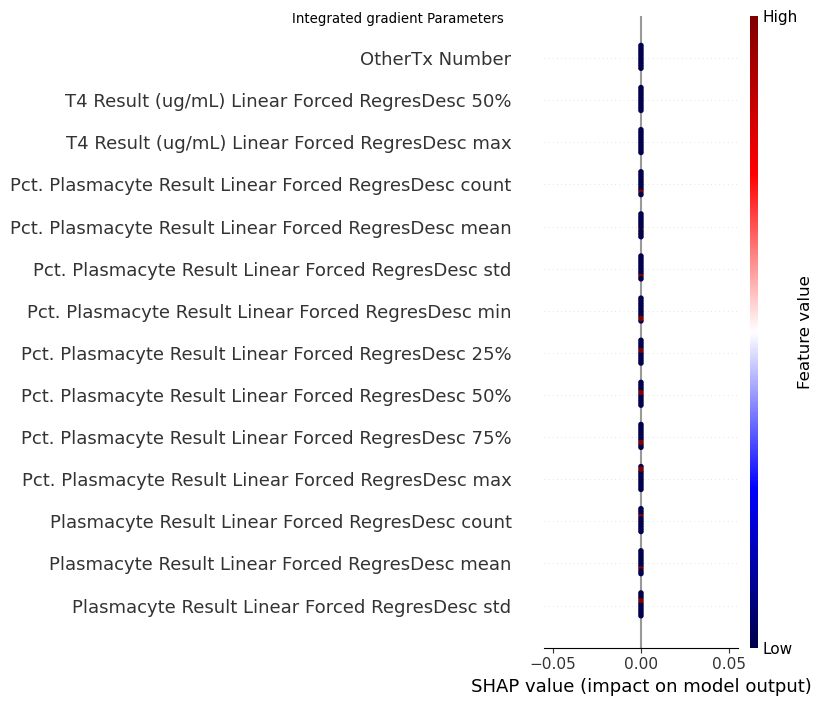

In [66]:
# number_feat_perf_test = 25
fig = shap.summary_plot(IG,  CV_sets[fold]["test"]["X"], max_display=number_feat_perf_test , 
                  feature_names=X.columns,cmap="seismic", show = False)
plt.suptitle("Integrated gradients of features")
figCommon = fileName_common + "fig5"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

### update: 
update the below block to take the highest performing feature?

In [67]:
# Xcv = pd.DataFrame(CV_sets[fold]["test"]["X"], 
#                      index=CV_sets[fold]["test"]["y"],
#                      columns=X.columns)

# shap.dependence_plot('ECOG Performance Status binary ', IG, Xcv, show = False)

# figCommon = fileName_common + "fig6"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.savefig(figPath, bbox_inches = 'tight')

In [68]:
np.argsort(CV_sets[fold]["test"]["y"].values)

array([0, 1, 3, 5, 9, 2, 4, 6, 7, 8])

In [69]:
topFeaturesNumber = number_feat_perf_test

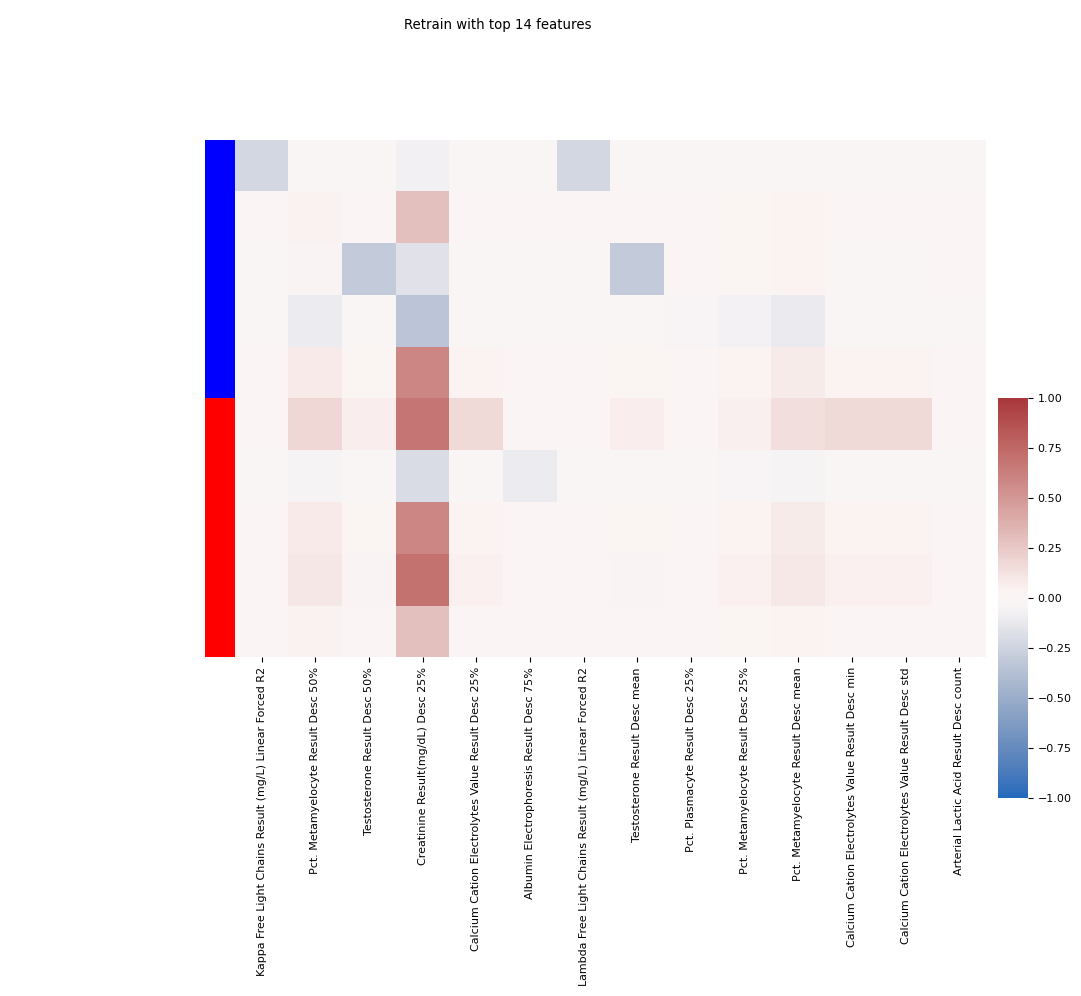

In [76]:
Xtop3 = pd.DataFrame(CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber ].astype(int)], 
                     index=CV_sets[fold]["test"]["y"],
                     columns=X.columns[featRank_D["sorted"][0:topFeaturesNumber ].astype(int)])
IG = compute_SV_integrated_gradient(tesTune2["best_models"][fold],
                                   CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber].astype(int)])

IGtable = pd.DataFrame(IG, index=CV_sets[fold]["test"]["y"],columns=X.columns[featRank_D["sorted"][0:topFeaturesNumber].astype(int)])

IGtable.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=-1, vmax=1,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[fold]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])

plt.suptitle("Integrated Gradients training with top "+ str(topFeaturesNumber) +' features')
plt.show()

figCommon = fileName_common + "fig7"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

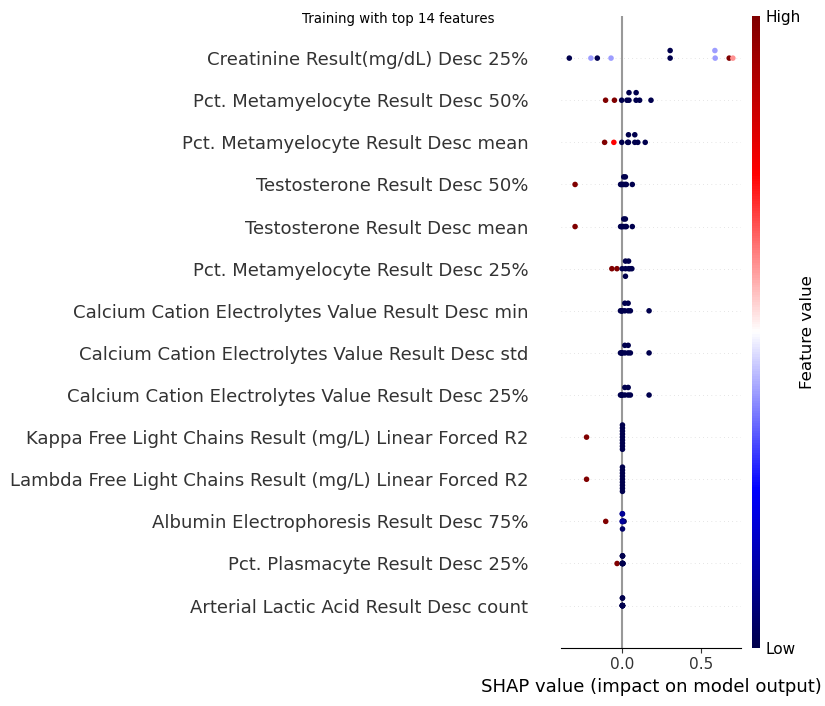

In [71]:
fig = shap.summary_plot(IG,  CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber ].astype(int)], max_display=topFeaturesNumber , 
                  feature_names=X.columns[featRank_D["sorted"][0:topFeaturesNumber ].astype(int)],cmap="seismic", show = False)
plt.suptitle("Integrated Gradient Parameters Training with top "+ str(topFeaturesNumber) +' features')
# plt.show()

figCommon = fileName_common + "fig8"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

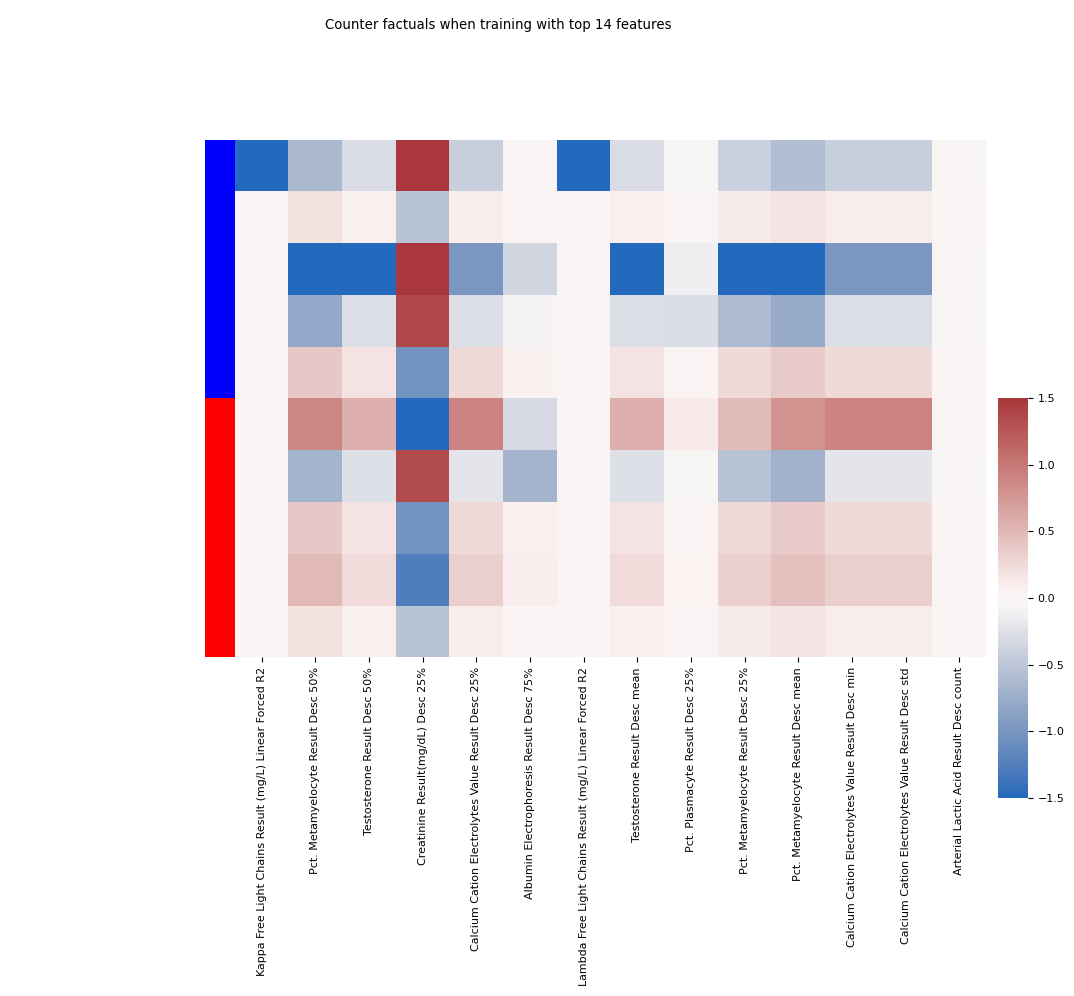

In [72]:
counterfactuals = compute_counterfactuals(tesTune2["best_models"][fold], 
                                          CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber].astype(int)])
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets[fold]["test"]["y"],columns=X.columns[featRank_D["sorted"][0:topFeaturesNumber].astype(int)])

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=-1.5, vmax=1.5,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets[fold]["test"]["y"].values[np.argsort(CV_sets[fold]["test"]["y"].values)]])
plt.suptitle("Counter factuals when training with top "+ str(topFeaturesNumber) +' features')
# plt.show()

figCommon = fileName_common + "fig9"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

In [73]:
# #pickling the tesTune object
# pickle_file = open('tesTune2_object_file', 'wb')
# pickle.dump(tesTune2, pickle_file)

In [74]:
pickle_file_name = 'tesTune2_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(tesTune2, pickle_file)